In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import importlib
import models
importlib.reload(models)
from models import Tick, Route, get_engine, get_sessionmaker, upsert
pd.set_option('display.expand_frame_repr', False) # display full data in terminal
%matplotlib inline

engine = get_engine()
Session = get_sessionmaker(engine)

with Session() as session:
    session.query(Tick).filter(Tick.lead_style == 'Pinkpoint').update({Tick.lead_style: 'Redpoint'}, synchronize_session='fetch')
    session.commit()


In [46]:
# Since I already did a bunch of processing of the raw data using dataframes, i'm just going to load the `grouped_ticks.csv`, (which was generated by 1_climbing_analysis_eda.ipynb) and insert them into the `Route` table.

df = pd.read_csv('/app/csv_files/grouped_ticks.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()
df['alpine'] = df['alpine'].fillna(0).astype(bool)
df['safety'] = df['safety'].fillna('G')

with Session() as session:
    df.to_sql('routes', con=engine, if_exists='append', index=False)
    all_routes = session.query(Route).all()

/tmp/ipykernel_63/1729940344.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(grade_map.keys(), fontsize=14)


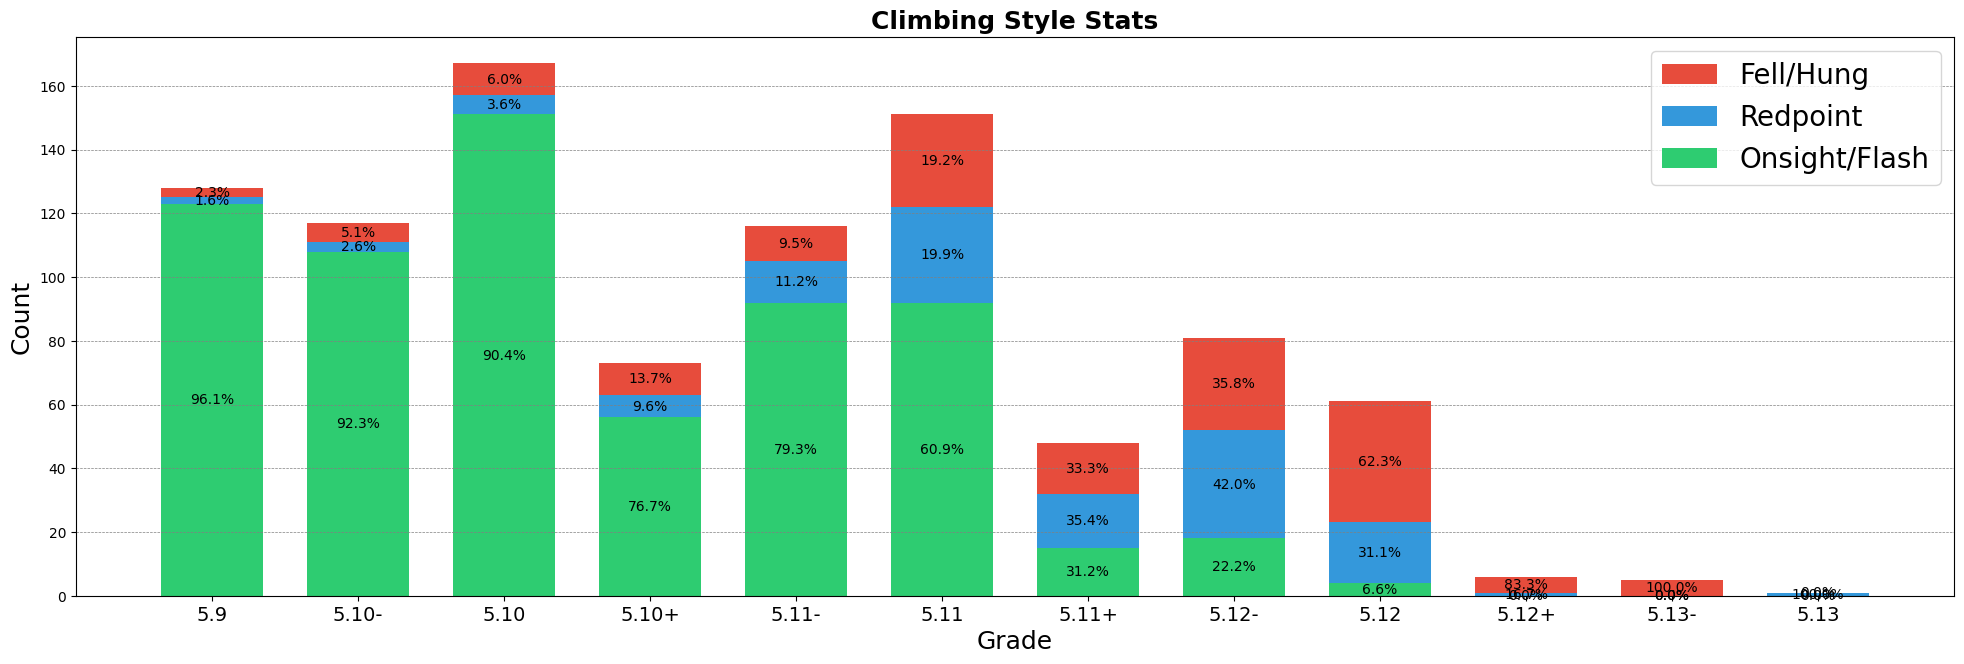

In [185]:
# visualize sends/attempts by grade.
distinct_ratings = df['rating'].unique()
# easy grades = []'5.5','5.6','5.7','5.7+','5.8-','5.8','5.8+','5.9-','5.9','5.9+]
# grade_order = ['5.10-','5.10a','5.10a/b','5.10b','5.10','5.10b/c','5.10c','5.10c/d','5.10d','5.10+','5.11-','5.11a','5.11a/b','5.11b','5.11','5.11b/c','5.11c','5.11c/d','5.11d','5.11+','5.12-','5.12a','5.12a/b','5.12b','5.12','5.12b/c','5.12c','5.12c/d','5.12d','5.13a','5.13b']
grade_map = {
    '5.9': ['5.9-','5.9','5.9+'],
    '5.10-': ['5.10-','5.10a','5.10a/b'],
    '5.10':  ['5.10b','5.10','5.10b/c', '5.10c'],
    '5.10+': ['5.10c/d','5.10d','5.10+'],
    '5.11-': ['5.11-','5.11a','5.11a/b'],
    '5.11':  ['5.11b','5.11','5.11b/c','5.11c'],
    '5.11+': ['5.11c/d','5.11d','5.11+'],
    '5.12-': ['5.12-','5.12a','5.12a/b'],
    '5.12':  ['5.12b','5.12','5.12b/c','5.12c'],
    '5.12+': ['5.12c/d','5.12d','5.12+'],   
    '5.13-': ['5.13-','5.13a','5.13a/b'],
    '5.13':  ['5.13b','5.13','5.13b/c','5.13c'],
}

os_flash, redpoint, fell_hung = [], [], []

# populate the above arrays with counts for each grade
for grade, grade_list in grade_map.items():
    routes = df[df['rating'].isin(grade_list)]
    os_count = routes[routes['lead_style'] == 'Onsight/Flash'].shape[0]
    rp_count = routes[routes['lead_style'] == 'Redpoint'].shape[0]
    fh_count = routes[routes['lead_style'] == 'Fell/Hung'].shape[0]
    os_flash.append(os_count)
    redpoint.append(rp_count)
    fell_hung.append(fh_count)

### GH copilot assisted with the styling of this bar chart:
style_counts = {
    'Onsight/Flash': np.array(os_flash),
    'Redpoint': np.array(redpoint),
    'Fell/Hung': np.array(fell_hung) 
}

fig, ax = plt.subplots(figsize=(20, 7))
width = 0.7
bottom = np.zeros(len(grade_map.keys()))
colors = ['#2ecc71', '#3498db', '#e74c3c']

total_counts = np.sum(list(style_counts.values()), axis=0)

def annotate_bars(bars, style_count):
    for bar, count, total in zip(bars, style_count, total_counts):
        percentage = (count / total) * 100 if total > 0 else 0
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            f'{percentage:.1f}%',
            ha='center',
            va='center',
            fontsize=10
        )

# Plot each style as a stacked bar
for i, (style, style_count) in enumerate(style_counts.items()):
    bars = ax.bar(grade_map.keys(), style_count, label=style, width=width, bottom=bottom, color=colors[i])
    annotate_bars(bars, style_count)
    bottom += style_count

ax.set_title("Climbing Style Stats", fontsize=18, fontweight='bold')
ax.set_xticklabels(grade_map.keys(), fontsize=14)
ax.set_ylabel('Count', fontsize=18)
ax.set_xlabel('Grade', fontsize=18)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', axis='y')

# Reorder handles and labels
desired_order = ['Fell/Hung', 'Redpoint', 'Onsight/Flash']
handles, labels = ax.get_legend_handles_labels()
ordered_handles = [handles[labels.index(style)] for style in desired_order]
ordered_labels = [style for style in desired_order]
ax.legend(ordered_handles, ordered_labels, loc='best', fontsize=20)

plt.tight_layout(pad=2)
plt.show()